# Imports

In [1]:
%pip install -r requirements3_11.txt

Note: you may need to restart the kernel to use updated packages.


In [1]:
import rdflib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
import random

In [22]:
t = 'Static'
i = 800
f = 0

X_train1 = pd.read_csv('DB/'+t+'/T'+str(i)+'/X_train_Fold'+str(f)+'.csv', sep=',',dtype=str,header=None)
y_train = pd.read_csv('DB/'+t+'/T'+str(i)+'/y_train_Fold'+str(f)+'.csv', sep=',',header=None)
X_test1 = pd.read_csv('DB/Uniform/T800/X_test_Fold'+str(f)+'.csv', sep=',',dtype=str,header=None)
y_test = pd.read_csv('DB/Uniform/T800/y_test_Fold'+str(f)+'.csv', sep=',',header=None).to_numpy().ravel()
sample_weight = pd.read_csv('DB/'+t+'/T'+str(i)+'/sample_weight_train_Fold'+str(f)+'.csv', sep=',',header=None)

X_train1 = X_train1[~X_train1.isin(X_test1)].dropna()
indexes = X_train1.index
X_train1 = X_train1.to_numpy(dtype=str)
y_train = y_train.iloc[indexes].dropna().to_numpy().ravel()
sample_weight = sample_weight.iloc[indexes].dropna().to_numpy().ravel()
X_test1 = X_test1.to_numpy(dtype=str)

# Files

In [6]:
gene_ontology_file_path = '../DB/go.owl'
protein_file_path = '../DB/9606.protein.enrichment.terms.v12.0.txt'
protein_links_file_path = '../DB/9606.protein.links.v12.0.txt'
protein_full_links_file_path = 'DB/9606.protein.links.detailed.v12.0.txt'
semantic_similarity_file_path = '../DB/NegativeSamplesUncertainty.csv'
gene_ontology_annotated_file_path = '../DB/go_annotated.owl'

# Creating the Knowledge graph

In [4]:
#g = rdflib.Graph()
#g.parse(gene_ontology_annotated_file_path, format = 'xml');

prots = pd.read_csv(protein_file_path, sep='\t', header=0)
prots = prots[prots['term'].str.startswith('GO:')].reset_index(drop=True)
prots = prots['#string_protein_id'].unique().tolist()

g = rdflib.Graph()
g.parse(gene_ontology_file_path, format = 'xml');

prots = []

with open(protein_file_path , 'r') as prot_annot:
    prot_annot.readline()
    for line in prot_annot:
        elements_annot = line.split('\t')
        id_prot, GO_term = elements_annot[0], elements_annot[2]
        if GO_term.startswith('GO:') :
            url_GO_term = 'http://purl.obolibrary.org/obo/GO_' + GO_term.split(':')[1]
            url_prot = 'https://string-db.org/network/' + id_prot
            if id_prot not in prots:
                prots.append(id_prot)
            g.add((rdflib.term.URIRef(url_prot), rdflib.term.URIRef('http://purl.obolibrary.org/obo/go.owl#has_function') , rdflib.term.URIRef(url_GO_term)))

# Distribution of Confidence

In [5]:
data_full = pd.read_csv(protein_full_links_file_path, sep=" ", header=0)
data_full = data_full[data_full["protein1"].isin(prots) & data_full["protein2"].isin(prots)]

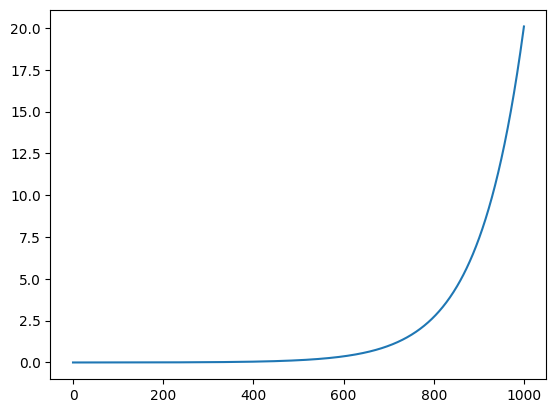

In [7]:
x = np.linspace(0, 1000, 1000)
y = np.exp(0.01 * (x - 700))

plt.plot(x, y)
plt.show()

In [6]:
# mean of confidence score
mean = data_full['combined_score'].mean()
mean

269.316800039109

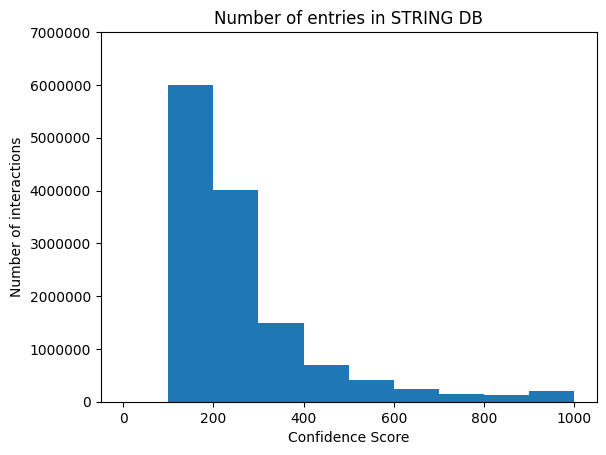

In [7]:
# Create a histogram and get the patches
counts, bins, patches = plt.hist(data_full['combined_score'], bins=10, bottom=list(range(0,1000,100)), range=(0,1000))

# Set the title and labels
plt.title('Number of entries in STRING DB')
plt.xlabel('Confidence Score')
plt.ylabel('Number of interactions')

# Annotate histogram with the number of data points in each bin
# for count, bin, patch in zip(counts, bins, patches):
#     height = patch.get_height()
#     plt.text(bin, height, str(int(count)), va='bottom', fontsize=7.5)

# Change the format of y-axis labels to display as percentages
plt.yticks(plt.yticks()[0], ['{}'.format(int(tick)) for tick in plt.yticks()[0]])


plt.show()

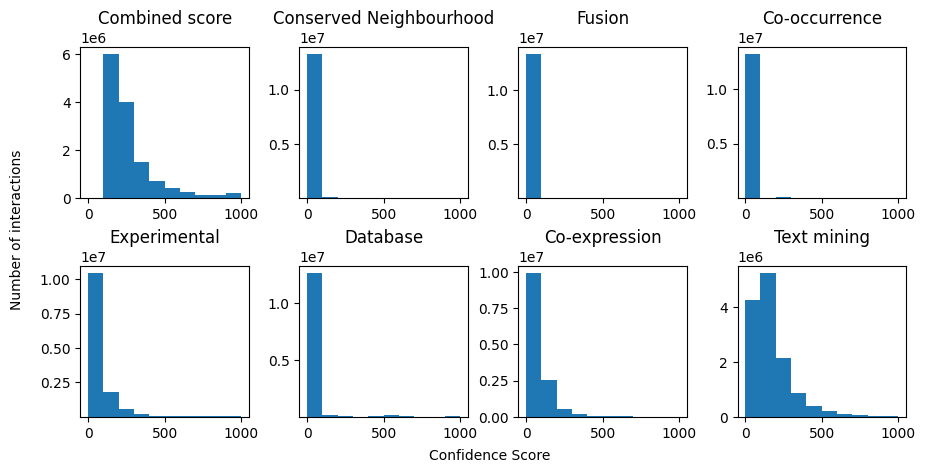

In [8]:
fig, axs = plt.subplots(2, 4)
axs[0, 0].hist(data_full['combined_score'], bins=10, bottom=list(range(0, 1000, 100)), range=(0, 1000))
axs[0, 0].set_title('Combined score', y=1.1)  # Increase the y parameter to move the title up
axs[0, 1].hist(data_full['neighborhood'], bins=10, bottom=list(range(0, 1000, 100)), range=(0, 1000))
axs[0, 1].set_title('Conserved Neighbourhood', y=1.1)
axs[0, 2].hist(data_full['fusion'], bins=10, bottom=list(range(0, 1000, 100)), range=(0, 1000))
axs[0, 2].set_title('Fusion', y=1.1)
axs[0, 3].hist(data_full['cooccurence'], bins=10, bottom=list(range(0, 1000, 100)), range=(0, 1000))
axs[0, 3].set_title('Co-occurrence', y=1.1)
axs[1, 0].hist(data_full['experimental'], bins=10, bottom=list(range(0, 1000, 100)), range=(0, 1000))
axs[1, 0].set_title('Experimental', y=1.1)
axs[1, 1].hist(data_full['database'], bins=10, bottom=list(range(0, 1000, 100)), range=(0, 1000))
axs[1, 1].set_title('Database', y=1.1)
axs[1, 2].hist(data_full['coexpression'], bins=10, bottom=list(range(0, 1000, 100)), range=(0, 1000))
axs[1, 2].set_title('Co-expression', y=1.1)
axs[1, 3].hist(data_full['textmining'], bins=10, bottom=list(range(0, 1000, 100)), range=(0, 1000))
axs[1, 3].set_title('Text mining', y=1.1)

fig.text(0.65, 0.02, 'Confidence Score', ha='center')
fig.text(-0.1, 0.5, 'Number of interactions', va='center', rotation='vertical')

plt.subplots_adjust(left=0.01, right=1.3, hspace=0.45,wspace=0.3)


In [9]:
# negatives = pd.read_csv(semantic_similarity_file_path, header=0, index_col=0,dtype={'Entity A': str, 'Entity B': str}).sort_values(by=['BMA_Seco2004'], ascending=True).reset_index()
# negatives['BMA_Seco2004'] = (1-negatives['BMA_Seco2004']) * 1000
# negatives['Entity A'] = 'https://string-db.org/network/9606.ENSP' + negatives['Entity A']
# negatives['Entity B'] = 'https://string-db.org/network/9606.ENSP' + negatives['Entity B']

In [10]:
# # Create a histogram and get the patches
# counts, bins, patches = plt.hist(negatives['BMA_Seco2004'], bins=10, bottom=list(range(0,1000,100)), range=(0,1000))

# # Set the title and labels
# plt.title('Distribution of Confidence Score based on Semantic Similarity')
# plt.xlabel('Confidence Score')
# plt.ylabel('Number of interactions')

# # Annotate histogram with the number of data points in each bin
# for count, bin, patch in zip(counts, bins, patches):
#     height = patch.get_height()
#     plt.text(bin, height, str(int(count)), va='bottom', fontsize=7.5)

# plt.show()

# Creating thresholds

In [12]:
fulldata8 = data_full[data_full['combined_score'] > 800]
setsize = int(len(fulldata8)/2)
train_data8 = fulldata8.sample(n=setsize, random_state=42)
dt8 = data_full[~data_full.isin(train_data8)].dropna().sort_values(by=['combined_score'], ascending=False).reset_index(drop=True)
select = [int((N*len(dt8))/setsize) for N in range(setsize)]
test_data8 = dt8.loc[select]

In [11]:
# Thresholds for the whole dataset

# data8 = data_full.where(data_full['combined_score']>800).dropna().reset_index(drop=True)
# data6 = data_full.where(data_full['combined_score']>600).dropna().reset_index(drop=True)
# data4 = data_full.where(data_full['combined_score']>400).dropna().reset_index(drop=True)
# data2 = data_full.where(data_full['combined_score']>200).dropna().reset_index(drop=True)
# dataSample = data_full

# Thresholds for fixed size sampling (1000 samples)

# data8 = data_full.where(data_full['combined_score']>800).dropna().reset_index(drop=True).sample(n=1000, random_state=42)
# data6 = data_full.where(data_full['combined_score']>600).dropna().reset_index(drop=True).sample(n=1000,random_state=42)
# data4 = data_full.where(data_full['combined_score']>400).dropna().reset_index(drop=True).sample(n=1000,random_state=42)
# data2 = data_full.where(data_full['combined_score']>200).dropna().reset_index(drop=True).sample(n=1000,random_state=42)
# dataSample = data_full.sample(n=1000,random_state=42)

# Thresholds for fraction sampling (10% of the data)

data8 = data_full.where(data_full['combined_score']>800).dropna().reset_index(drop=True).sample(frac=0.1, random_state=42)
data6 = data_full.where(data_full['combined_score']>600).dropna().reset_index(drop=True).sample(frac=0.1,random_state=42)
data4 = data_full.where(data_full['combined_score']>400).dropna().reset_index(drop=True).sample(frac=0.1,random_state=42)
data2 = data_full.where(data_full['combined_score']>200).dropna().reset_index(drop=True).sample(frac=0.1,random_state=42)
dataSample = data_full.sample(frac=0.1,random_state=42)


# Thresholds for uniform sampling

# select = []
# for N in range(1000):
#    ind = int(N*len(data8)/1000)
#    select.append(ind)
# data8 = data8.loc[select]
# select = []
# for N in range(1000):
#    ind = int(N*len(data6)/1000)
#    select.append(ind)
# data6 = data6.loc[select]
# select = []
# for N in range(1000):
#    ind = int(N*len(data4)/1000)
#    select.append(ind)
# data4 = data4.loc[select]
# select = []
# for N in range(1000):
#    ind = int(N*len(data8)/1000)
#    select.append(ind)
# data2 = data2.loc[select]
# select = []
# for N in range(1000):
#    ind = int(N*len(dataSample)/1000)
#    select.append(ind)
# dataSample = dataSample.reset_index(drop=True).loc[select]


# Thresholds for training with data above 800 and testing with data below 800
# train = data_full.where(data_full['combined_score']>800).dropna().reset_index(drop=True).sample(frac=0.1,random_state=42)
# test = data_full.where(data_full['combined_score']<800).dropna().reset_index(drop=True).sample(frac=0.1,random_state=42)

all_negative_pairs_prots = []
# Without semantic similarity
pairs_prots_STRING = set()
for d in data_full.values:
    pairs_prots_STRING.add(('https://string-db.org/network/' + d[0],'https://string-db.org/network/' + d[1], 1))
# Creating a list of all proteins
prots_links = ['https://string-db.org/network/' + prot for prot in prots]
for prot in prots_links:
    for prot2 in prots_links:
        if (prot,prot2,1) in pairs_prots_STRING or (prot2,prot,1) in pairs_prots_STRING:
            continue
        elif prot != prot2:
            all_negative_pairs_prots.append((prot,prot2,0))

all_negative_pairs_prots = list(set(all_negative_pairs_prots))

del pairs_prots_STRING
del prots_links

# With semantic similarity
# for n in negatives.values:
#     all_negative_pairs_prots.append((n[1],n[2],0))
#
# del negatives

del data_full
del prots

In [7]:
embedCSV = pd.read_csv('DB/HuriTest/embeddings_train.csv',index_col=0)
prots = embedCSV.index.tolist()
prots = [sample.replace('https://string-db.org/network/', '') for sample in prots]

# Distribution of Confidence
data_full = pd.read_csv(protein_full_links_file_path, sep=" ", header=0)
data_full = data_full[data_full["protein1"].isin(prots) & data_full["protein2"].isin(prots)].sort_values(by=['combined_score'], ascending=False).reset_index(drop=True)

all_negative_pairs_prots = []
# Without semantic similarity
pairs_prots_STRING = set()
for d in data_full.values:
    pairs_prots_STRING.add(('https://string-db.org/network/' + d[0],'https://string-db.org/network/' + d[1], 1))
# Creating a list of all proteins
prots_links = ['https://string-db.org/network/' + prot for prot in prots]
for prot in prots_links:
    for prot2 in prots_links:
        if (prot,prot2,1) in pairs_prots_STRING or (prot2,prot,1) in pairs_prots_STRING:
            continue
        elif prot != prot2:
            all_negative_pairs_prots.append((prot,prot2,0))

all_negative_pairs_prots = list(set(all_negative_pairs_prots))

all_negative_pairs_prots = pd.DataFrame(all_negative_pairs_prots, columns=['protein1', 'protein2', 'interaction'])
STRING_negative_pairs_prots = all_negative_pairs_prots.sample(n = len(data_full), random_state=42)
STRING_negative_pairs_prots.to_csv('DB/negative_pairs_prots.csv', index=False)

In [31]:
all_negative_pairs_prots = pd.read_csv('DB/negative_pairs_prots.csv', header=0)
all_negative_pairs_prots = list(tuple(x) for x in all_negative_pairs_prots.to_numpy())

[('https://string-db.org/network/9606.ENSP00000261797',
  'https://string-db.org/network/9606.ENSP00000361043',
  0),
 ('https://string-db.org/network/9606.ENSP00000359707',
  'https://string-db.org/network/9606.ENSP00000261507',
  0),
 ('https://string-db.org/network/9606.ENSP00000437910',
  'https://string-db.org/network/9606.ENSP00000484852',
  0),
 ('https://string-db.org/network/9606.ENSP00000442701',
  'https://string-db.org/network/9606.ENSP00000262848',
  0),
 ('https://string-db.org/network/9606.ENSP00000426191',
  'https://string-db.org/network/9606.ENSP00000326042',
  0),
 ('https://string-db.org/network/9606.ENSP00000367316',
  'https://string-db.org/network/9606.ENSP00000216923',
  0),
 ('https://string-db.org/network/9606.ENSP00000399970',
  'https://string-db.org/network/9606.ENSP00000433205',
  0),
 ('https://string-db.org/network/9606.ENSP00000381005',
  'https://string-db.org/network/9606.ENSP00000464357',
  0),
 ('https://string-db.org/network/9606.ENSP00000494017',


# Pipeline

# Imports
from pyrdf2vec.graphs import kg
from pyrdf2vec.rdf2vec import RDF2VecTransformer
from pyrdf2vec.embedders import Word2Vec
from pyrdf2vec.samplers import UniformSampler, ObjFreqSampler, PredFreqSampler
from pyrdf2vec.walkers import RandomWalker, WeisfeilerLehmanWalker, WalkletWalker

# Defining rdf2vec paramenters
vector_size = 200
n_walks = 100
type_word2vec = 'skip-gram'
walk_depth = 4
walker_type = 'wl'
sampler_type = 'uniform'

# Creating a pyrdf2vec graph
# Creating a pyrdf2vec graph
# g_pyrdf2vec = kg.KG(mul_req=False)
# for (s, p, o) in g:
#     s_v = Vertex(str(s))
#     o_v = Vertex(str(o))
#     p_v = Vertex(str(p), predicate=True, vprev=s_v, vnext=o_v)
#     g_pyrdf2vec.add_vertex(s_v)
#     g_pyrdf2vec.add_vertex(p_v)
#     g_pyrdf2vec.add_vertex(o_v)
#     g_pyrdf2vec.add_edge(s_v, p_v)
#     g_pyrdf2vec.add_edge(p_v, o_v)

g_pyrdf2vec = kg.KG("../DB/go_annotated.owl", mul_req=False)

# Defining the word2vec strategy
if type_word2vec == 'CBOW':
    sg_value = 0
elif type_word2vec == 'skip-gram':
    sg_value = 1

# Defining sampling strategy
if sampler_type.lower() == 'uniform':
    sampler = UniformSampler()
elif sampler_type.lower() == 'predfreq':
    sampler = PredFreqSampler()
elif sampler_type.lower() == 'objfreq':
    sampler = ObjFreqSampler()

# Defining walker strategy
if walker_type.lower() == 'random':
    walker = RandomWalker(depth=walk_depth, walks_per_graph=n_walks, sampler = sampler, n_jobs = -1)
elif walker_type.lower() == 'wl':
    walker = WeisfeilerLehmanWalker(depth=walk_depth, walks_per_graph=n_walks, sampler = sampler, n_jobs = -1)
#   walker = WLWalker(max_depth=walk_depth, max_walks=n_walks, sampler = sampler)
elif walker_type.lower() == 'walklet':
    walker = WalkletWalker(depth=walk_depth, walks_per_graph=n_walks, sampler = sampler, n_jobs = -1 )

# testing RDF2Vec embeddings
transformer = RDF2VecTransformer(Word2Vec(size=vector_size, sg=sg_value), walkers=[walker])

# Generating the embeddings
embeddings = transformer.fit_transform(g_pyrdf2vec, prots)
dict_embeddings = {prots[i]: embeddings[i] for i in range(len(prots))}
dict_embeddings.to_csv('DB/embeddings.csv', index=True)

In [9]:
embedCSV = pd.read_csv('../DB/embeddings.csv',index_col=0)
embeddings_array = np.array(list(embedCSV.values))
dict_embeddings = {embedCSV.index[i]: embeddings_array[i] for i in range(len(embeddings_array))}
vector_size = embedCSV.shape[1]
random.seed(42)

In [18]:
f1_results = {} # list of f1 results

f1_to_csv = {}

for i in range(800, -1, -200):
    if i == 800:
        data = data8
    elif i == 600:
        data = data6
    elif i == 400:
        data = data4
    elif i == 200:
        data = data2
    elif i == 0:
        data = dataSample

    pairs_prots = []
    for d in data.values:
        pairs_prots.append(('https://string-db.org/network/' + d[0],'https://string-db.org/network/' + d[1], 1))

    # Without semantic similarity
    negative_pairs_prots = random.sample(all_negative_pairs_prots, len(pairs_prots))
    # With semantic similarity
    #negative_pairs_prots = all_negative_pairs_prots[:len(pairs_prots)]    

    # Sample weight
    sample_weight = list(data['combined_score'].values)
    sample_weight.extend([1000 for i in range(0, len(pairs_prots))])
    sample_weight = np.array(sample_weight)
    
    # Generating pair representations using hadamard operator # other possibilities are concatenation, wl-1 or wl-2
    X, y = [], []
    for prot1, prot2, label in pairs_prots:
        emb_prot1 = dict_embeddings[prot1].reshape(1, vector_size)
        emb_prot2 = dict_embeddings[prot2].reshape(1, vector_size)
        hada = np.multiply(emb_prot1, emb_prot2)
        X.append(hada.tolist()[0])
        y.append(int(label))

    for prot1, prot2, label in negative_pairs_prots:
        emb_prot1 = dict_embeddings[prot1].reshape(1, vector_size)
        emb_prot2 = dict_embeddings[prot2].reshape(1, vector_size)
        hada = np.multiply(emb_prot1, emb_prot2)
        X.append(hada.tolist()[0])
        y.append(int(label))

    f1 = []

    # Creating training set and test set
    skf = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)
    X, y = np.array(X), np.array(y)
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        sample_weight_train = sample_weight[train_index]
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

        # Training Random Forest classifier
        rf_model = RandomForestClassifier(n_jobs=-1, random_state=42)
        rf_model.fit(X_train, y_train,sample_weight=sample_weight_train)

        # Obtaining predictions
        pred_test = rf_model.predict(X_test)

        # Computing performance metrics
        weighted_avg_f1 = metrics.f1_score(y_test, pred_test, average='weighted')
        f1.append(weighted_avg_f1)

    f1_to_csv[i] = f1
    
    f1_mean = np.mean(f1)

    f1_min_mean_max =[np.min(f1), f1_mean, np.max(f1)]
    
    f1_results[i] = f1_min_mean_max

    # Printing performance metrics
    print('Weighted Average F-measure for ' + str(i) + ' or more confidence score= ' + str(f1_mean))

df = pd.DataFrame.from_dict(f1_to_csv, orient='index')
df.to_csv('../Results/f1_results_Fraction10.csv')

Weighted Average F-measure for 800 or more confidence score= 0.8634802779249556


# F-measure Analysis

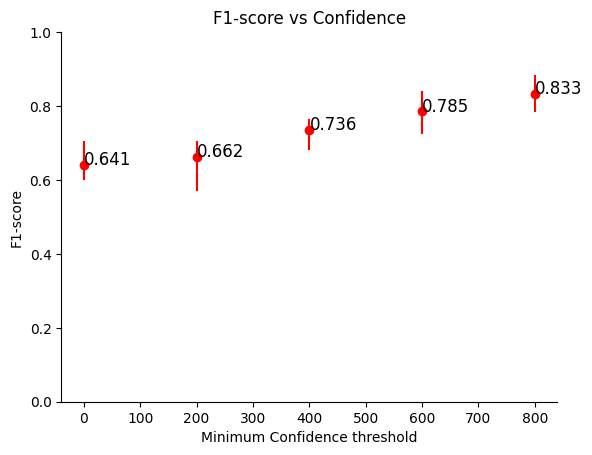

In [ ]:
f1_x = list(f1_results.keys())
f1_y = [f1_results[i][1] for i in f1_results.keys()]
y_errormin = [(np.abs(f1_results[i][1] - f1_results[i][0])) for i in f1_results.keys()]
y_errormax = [(np.abs(f1_results[i][2] - f1_results[i][1])) for i in f1_results.keys()]

# file = pd.read_csv('../Results/f1_results_fixed.csv', index_col=0)
# f1_x = [file.iloc[0].name, file.iloc[1].name, file.iloc[2].name, file.iloc[3].name, file.iloc[4].name]
# f1_y = [file.iloc[0].mean(), file.iloc[1].mean(), file.iloc[2].mean(), file.iloc[3].mean(), file.iloc[4].mean()]
# y_errormin = [np.abs(f1_y[i] - file.iloc[i].min()) for i in range(5)]
# y_errormax = [np.abs(f1_y[i] - file.iloc[i].max()) for i in range(5)]

y_error = [y_errormin, y_errormax]

plt.errorbar(f1_x, f1_y,
 
             yerr=y_error,
 
             fmt='o', color="r")

plt.xlabel('Minimum Confidence threshold')
plt.ylabel('F1-score')
plt.ylim(0,1)
plt.title('F1-score vs Confidence')
plt.gca().spines[['right', 'top']].set_visible(False)

#use for loop to add annotations to each point in plot 
for i, txt in enumerate(f1_y):
    plt.annotate(round(txt,3), (f1_x[i]+.25, f1_y[i]), fontsize=12)

plt.show()

# test 28 03


In [1]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import random,logging
from pathlib import Path
from pulearn import ElkanotoPuClassifier
logging.basicConfig(format='%(asctime)s %(levelname)-8s %(message)s',level = logging.INFO,datefmt='%Y-%m-%d %H:%M:%S')

def get_classifiers():
    classifiers = [
        RandomForestClassifier(n_jobs=-1, random_state=42),
        XGBClassifier(n_jobs=-1, random_state=42),
    ]
    return classifiers

# Files
protein_file_path = 'DB/9606.protein.enrichment.terms.v12.0.txt'
protein_full_links_file_path = 'DB/9606.protein.links.detailed.v12.0.txt'

# Creating the Knowledge graph
prots = pd.read_csv(protein_file_path, sep='\t', header=0)
prots = prots[prots['term'].str.startswith('GO:')].reset_index(drop=True)
prots = prots['#string_protein_id'].unique().tolist()

# Distribution of Confidence
data_full = pd.read_csv(protein_full_links_file_path, sep=" ", header=0)
data_full = data_full[data_full["protein1"].isin(prots) & data_full["protein2"].isin(prots)]
# mean of confidence score
mean = data_full['combined_score'].mean()

data8 = data_full.where(data_full['combined_score']>800).dropna().reset_index(drop=True)

setsize = int(len(data8)*5)

data = data_full.sample(n=setsize, random_state=42).dropna().reset_index(drop=True)

# Without semantic similarity
all_negative_pairs_prots = pd.read_csv('DB/negative_pairs_prots.csv', header=0)
all_negative_pairs_prots = list(tuple(x) for x in all_negative_pairs_prots.to_numpy())

del data_full
del prots
# Pipeline
embedCSV = pd.read_csv('DB/embeddings.csv',index_col=0)
embeddings_array = np.array(list(embedCSV.values))
dict_embeddings = {embedCSV.index[i]: embeddings_array[i] for i in range(len(embeddings_array))}
vector_size = embedCSV.shape[1]
random.seed(42)

f1_to_csv = {}

pairs_prots = []
for d in data.values:
    pairs_prots.append((d[0].split('9606.ENSP')[1],d[1].split('9606.ENSP')[1], d[-1]))

negative_pairs_prots = random.sample(all_negative_pairs_prots, len(pairs_prots))

In [2]:
X, y, sample_weight = [], [], []
for prot1, prot2, c in pairs_prots:
    X.append(2)
    y.append(1)
    sample_weight.append(c)

for prot1, prot2, label in negative_pairs_prots:
    X.append(2)
    y.append(0)
    sample_weight.append(mean)

metrics_to_csv = {}

skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
X, y ,sample_weight = np.array(X), np.array(y), np.array(sample_weight)
for j, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    sample_weight_train = sample_weight[train_index]

ValueError: Found input variables with inconsistent numbers of samples: [0, 3192260]

In [1]:
import pandas as pd
import random,logging

In [3]:

logging.basicConfig(format='%(asctime)s %(levelname)-8s %(message)s',level = logging.INFO,datefmt='%Y-%m-%d %H:%M:%S')

# Files
protein_file_path = 'DB/9606.protein.enrichment.terms.v12.0.txt'
protein_full_links_file_path = 'DB/9606.protein.links.detailed.v12.0.txt'

# Creating the Knowledge graph
prots = pd.read_csv(protein_file_path, sep='\t', header=0)
prots = prots[prots['term'].str.startswith('GO:')].reset_index(drop=True)
prots = prots['#string_protein_id'].unique().tolist()

# Distribution of Confidence
data_full = pd.read_csv(protein_full_links_file_path, sep=" ", header=0)
data_full = data_full[data_full["protein1"].isin(prots) & data_full["protein2"].isin(prots)].sort_values(by=['combined_score'], ascending=False).reset_index(drop=True)

mean = data_full['combined_score'].mean()

# Creating thresholds
fulldata8 = data_full[data_full['combined_score'] > 800]
setsize = int(len(fulldata8))

del fulldata8

# Pipeline
random.seed(42)

In [11]:
logging.info("Starting Static dataset building ...")

for i in range(800, -1, -200):
    if i == 800:
        data = data_full.where(data_full['combined_score']>800).dropna().reset_index(drop=True).sample(n=setsize,random_state=42)
    elif i == 600:
        data = data_full.where(data_full['combined_score']>600).dropna().reset_index(drop=True).sample(n=setsize,random_state=42)
    elif i == 400:
        data = data_full.where(data_full['combined_score']>400).dropna().reset_index(drop=True).sample(n=setsize,random_state=42)
    elif i == 200:
        data = data_full.where(data_full['combined_score']>200).dropna().reset_index(drop=True).sample(n=setsize,random_state=42)
    elif i == 0:
        data = data_full.sample(n=setsize,random_state=42)
    
    print('Threshold: ', i, 'Data size: ', len(data))
    
    data8 = data.where(data['combined_score']>800).dropna().reset_index(drop=True)
    data6 = data.where((data['combined_score'] > 600) & (data['combined_score'] < 800)).dropna().reset_index(drop=True)
    data4 = data.where((data['combined_score'] > 400) & (data['combined_score'] < 600)).dropna().reset_index(drop=True)
    data2 = data.where((data['combined_score'] > 200) & (data['combined_score'] < 400)).dropna().reset_index(drop=True)
    data0 = data.where(data['combined_score'] < 200).dropna().reset_index(drop=True)
    
    print('Data8 size: ', len(data8))
    print('Data6 size: ', len(data6))
    print('Data4 size: ', len(data4))
    print('Data2 size: ', len(data2))
    print('Data0 size: ', len(data0))

2024-05-20 14:11:08 INFO     Starting Static dataset building ...


Threshold:  800 Data size:  319226
Data8 size:  319226
Data6 size:  0
Data4 size:  0
Data2 size:  0
Data0 size:  0
Threshold:  600 Data size:  319226
Data8 size:  143424
Data6 size:  174399
Data4 size:  0
Data2 size:  0
Data0 size:  0
Threshold:  400 Data size:  319226
Data8 size:  56357
Data6 size:  68456
Data4 size:  193382
Data2 size:  0
Data0 size:  0
Threshold:  200 Data size:  319226
Data8 size:  13963
Data6 size:  16912
Data4 size:  48171
Data2 size:  238970
Data0 size:  0
Threshold:  0 Data size:  319226
Data8 size:  7615
Data6 size:  9225
Data4 size:  25872
Data2 size:  130438
Data0 size:  143572


In [12]:
logging.info("Starting Growing dataset building...")


for i in range(800, -1, -200):
    if i == 800:
        data = data_full.where(data_full['combined_score']>800).dropna().reset_index(drop=True).sample(frac=0.1,random_state=42)
    elif i == 600:
        data = data_full.where(data_full['combined_score']>600).dropna().reset_index(drop=True).sample(frac=0.1,random_state=42)
    elif i == 400:
        data = data_full.where(data_full['combined_score']>400).dropna().reset_index(drop=True).sample(frac=0.1,random_state=42)
    elif i == 200:
        data = data_full.where(data_full['combined_score']>200).dropna().reset_index(drop=True).sample(frac=0.1,random_state=42)
    elif i == 0:
        data = data_full.sample(frac=0.1,random_state=42)
    
    print('Threshold: ', i, 'Data size: ', len(data))
    data8 = data.where(data['combined_score']>800).dropna().reset_index(drop=True)
    data6 = data.where((data['combined_score'] > 600) & (data['combined_score'] < 800)).dropna().reset_index(drop=True)
    data4 = data.where((data['combined_score'] > 400) & (data['combined_score'] < 600)).dropna().reset_index(drop=True)
    data2 = data.where((data['combined_score'] > 200) & (data['combined_score'] < 400)).dropna().reset_index(drop=True)
    data0 = data.where(data['combined_score'] < 200).dropna().reset_index(drop=True)
    
    print('Data8 size: ', len(data8))
    print('Data6 size: ', len(data6))
    print('Data4 size: ', len(data4))
    print('Data2 size: ', len(data2))
    print('Data0 size: ', len(data0))

2024-05-20 14:11:28 INFO     Starting Growing dataset building...


Threshold:  800 Data size:  31923
Data8 size:  31923
Data6 size:  0
Data4 size:  0
Data2 size:  0
Data0 size:  0
Threshold:  600 Data size:  70836
Data8 size:  31669
Data6 size:  38878
Data4 size:  0
Data2 size:  0
Data0 size:  0
Threshold:  400 Data size:  180340
Data8 size:  31622
Data6 size:  38720
Data4 size:  109416
Data2 size:  0
Data0 size:  0
Threshold:  200 Data size:  726173
Data8 size:  31710
Data6 size:  38640
Data4 size:  109394
Data2 size:  543658
Data0 size:  0
Threshold:  0 Data size:  1333709
Data8 size:  32040
Data6 size:  38747
Data4 size:  108865
Data2 size:  543795
Data0 size:  599720


In [6]:
logging.info("Starting Uniform dataset building...")

for i in range(800, -1, -200):
    if i == 800:
        data8 = data_full.where(data_full['combined_score']>800).dropna().reset_index(drop=True).sample(n=setsize,random_state=42)
        data = data8
        print('Threshold size: ', len(data8))
    elif i == 600:
        data6 = data_full.where(data_full['combined_score']>600).where(data_full['combined_score']<=800).dropna().reset_index(drop=True).sample(n=setsize,random_state=42)
        data = pd.concat([data8,data6])
        print('Threshold size: ', len(data6))
    elif i == 400:
        data4 = data_full.where(data_full['combined_score']>400).where(data_full['combined_score']<=600).dropna().reset_index(drop=True).sample(n=setsize,random_state=42)
        data = pd.concat([data8,data6,data4])
        print('Threshold size: ', len(data4))
    elif i == 200:
        data2 = data_full.where(data_full['combined_score']>200).where(data_full['combined_score']<=400).dropna().reset_index(drop=True).sample(n=setsize,random_state=42)
        data = pd.concat([data8,data6,data4,data2])
        print('Threshold size: ', len(data2))
    elif i == 0:
        data0 = data_full.where(data_full['combined_score']<=200).dropna().reset_index(drop=True).sample(n=setsize,random_state=42)
        data = pd.concat([data8,data6,data4,data2,data0])
        print('Threshold size: ', len(data0))

    print('Threshold: ', i, 'subtotal size: ', len(data))


2024-05-20 12:21:04 INFO     Starting Uniform dataset building...


Threshold size:  319226
Threshold:  800 subtotal size:  319226
Threshold size:  319226
Threshold:  600 subtotal size:  638452
Threshold size:  319226
Threshold:  400 subtotal size:  957678
Threshold size:  319226
Threshold:  200 subtotal size:  1276904
Threshold size:  319226
Threshold:  0 subtotal size:  1596130


In [7]:
logging.info("Starting UnderSampled dataset building...")

for i in range(800, -1, -200):
    if i == 800:
        data8 = data_full.where(data_full['combined_score']>800).dropna().reset_index(drop=True).sample(n=setsize,random_state=42)
        data = data8
        print('Threshold size: ', len(data8))
    elif i == 600:
        data6 = data_full.where(data_full['combined_score']>600).where(data_full['combined_score']<=800).dropna().reset_index(drop=True).sample(n=int(setsize*(8/10)),random_state=42)
        data = pd.concat([data8,data6])
        print('Threshold size: ', len(data6))
    elif i == 400:
        data4 = data_full.where(data_full['combined_score']>400).where(data_full['combined_score']<=600).dropna().reset_index(drop=True).sample(n=int(setsize*(6/10)),random_state=42)
        data = pd.concat([data8,data6,data4])
        print('Threshold size: ', len(data4))
    elif i == 200:
        data2 = data_full.where(data_full['combined_score']>200).where(data_full['combined_score']<=400).dropna().reset_index(drop=True).sample(n=int(setsize*(4/10)),random_state=42)
        data = pd.concat([data8,data6,data4,data2])
        print('Threshold size: ', len(data2))
    elif i == 0:
        data0 = data_full.where(data_full['combined_score']<=200).dropna().reset_index(drop=True).sample(n=int(setsize*(2/10)),random_state=42)
        data = pd.concat([data8,data6,data4,data2,data0])
        print('Threshold size: ', len(data0))

    print('Threshold: ', i, 'subtotal size: ', len(data))

2024-05-20 12:21:50 INFO     Starting UnderSampled dataset building...


Threshold size:  319226
Threshold:  800 subtotal size:  319226
Threshold size:  255380
Threshold:  600 subtotal size:  574606
Threshold size:  191535
Threshold:  400 subtotal size:  766141
Threshold size:  127690
Threshold:  200 subtotal size:  893831
Threshold size:  63845
Threshold:  0 subtotal size:  957676
